# Function and imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as scp
import copy
import random
from sklearn.model_selection import StratifiedKFold
import scipy
import math
from sklearn.linear_model import LinearRegression

#Machine learning libraries 
import tensorflow as tf
import keras as keras 
from keras import models 
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical
import sklearn as skl
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

import pickle

C:\Users\Yassine\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Yassine\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Yassine\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Yassine\Anaconda3\envs\tensorflow\lib\site-

In [2]:
def Normalize(data1):
    D1 = copy.deepcopy(data1)
    Min = D1.min(); 
    Max = D1.max()
    D1 = (D1 - Min) / (Max - Min)
    
    return D1

def PutOffRedundant(AdjMatrix): #This function is used of vectorizing the structural connectivity matrix. 
    M = copy.deepcopy(AdjMatrix)
    for n in range(N):
        for i in range(90):
            for j in range(90):
                if i<=j:
                    M[i,j,n] = -1
    return M

def flatten_list(list_):
    new_list = []
    for i in list_:
        for j in i:
            new_list.append(j)
    return new_list


def Get_Mean_Absolute_Error(ytest, ypred):
    
    MAE_ = np.zeros(len(ytest), )
    
    for i in range(len(ytest)):
        MAE_[i] = np.abs(ytest[i]-ypred[i])
    return np.mean(MAE_)

def Performance_Scores(ytest_5folds, ypredicted_5folds):
    
    
    for i in range(len(ytest_5folds)):
        MAE_fold = Get_Mean_Absolute_Error(ytest_5folds[i], ypredicted_5folds[i])
        Corr_fold = scipy.stats.pearsonr(np.array(ytest_5folds[i]).flatten(), np.array(ypredicted_5folds[i]).flatten())
        print('For fold', str(i+1), ', MAE =', MAE_fold, ' and Correlation =', Corr_fold[0], 'with p value =',Corr_fold[1])
        
    ytest_flat = []
    ypred_flat = []
    for i in range(len(ytest_5folds)):
        for j in range(len(ytest_5folds[i])):
            ytest_flat.append(ytest_5folds[i][j])
            ypred_flat.append(ypredicted_5folds[i][j])
    
    Total_MAE = Get_Mean_Absolute_Error(ytest_flat, ypred_flat)
    Total_Corr = scipy.stats.pearsonr(np.array(ytest_flat).flatten(), np.array(ypred_flat).flatten())
    print('For total scores, MAE =', MAE_fold, ' and Correlation =', Corr_fold[0], 'with p value =',Corr_fold[1])
        
        
    
    

# Load data and preprocessing

In [3]:
#Load data from matlab struct - turn into np array, and verify shape is correct

Path_to_Connectivity = os.path.abspath('C:/Users/Yassine/Documents/3rd Year Project/Summer Work/Code/NewStructuralConnectivity.mat')
Data = scp.loadmat(Path_to_Connectivity)

PMA = np.array(Data.get('pma'))
GA = np.array(Data.get('ga'))
Sex = np.transpose(np.array(Data.get('sex')))
Structural = np.array(Data.get('SCmu'))
N = Structural.shape[2]
Names = Data.get('sub')
Subject_ID = [x.tolist()[0][4:] for x in Names[0]]

print('Shape of sex : ' , Sex.shape)
print('Shape of GA : ' , GA.shape)
print('Shape of PMA : ', PMA.shape)
print('Shape of Structural Matrix : ', Structural.shape)

Shape of sex :  (1, 524)
Shape of GA :  (524, 1)
Shape of PMA :  (524, 1)
Shape of Structural Matrix :  (90, 90, 524)


## Vectorize connectome 

In [4]:
# #Normalize structural connectome between 0 and 1
StructuralN = Normalize(Structural)

#Set redundant data to -1 
StrucuralNR = PutOffRedundant(StructuralN)

#Vectorise Structural connectomes 
S = np.transpose(np.reshape(StrucuralNR, (90*90, N)))

#Delete -1 elements 
Struc = S[S>-1]

#Reshape as vector of 4005 elements
X = np.reshape(Struc, (N, 4005))

We have 106 preterm subjects


## Select preterm subjects

In this section, we use the term trained PMA models to predict for preterm outcomes and compute correlation with outcomes. We thus separate preterm from terms neonates. 

In [ ]:
PreTermIndex = np.array(np.where(GA<37))[0,:]
NumberOfPreTerms = PreTermIndex.shape[0]

X_PreTerm = X[PreTermIndex,:]
GA_PreTerm = GA[PreTermIndex]
PMA_PreTerm__ = PMA[PreTermIndex]

PMA_PreTerm = [] 
for i in range(len(PMA_PreTerm__)):
    PMA_PreTerm.append(float(PMA_PreTerm__[i]))

Names_PreTerm = []
for i in range(len(Subject_ID)):
    if i in PreTermIndex:
        Names_PreTerm.append(Subject_ID[i])
    else:
        continue
print('We have', len(Names_PreTerm), 'preterm subjects')

# Apply trained model to preterm cohort

In [6]:
from keras.models import load_model

Corrected_Predictions_PreTerm = np.zeros((NumberOfPreTerms, 5)) #5 columns for each prediction

# Load models and predict PMA of each preterm subject
for i in range(5):
    print(i)
    Local_Model = load_model(str('PMA stuff/DNN/PMA_DNN_Model' + str(i) + '.h5'))
    with open('PMA stuff/DNN/Bias_Parameters_PMA_DNN.pkl', 'rb') as f:  
        PARAMS = pickle.load(f)
    
    for j in range(NumberOfPreTerms):
        Pred = Local_Model.predict(np.transpose(X_PreTerm[j, :].reshape(-1,1)))
        Corrected_Predictions_PreTerm[j, i] = Pred + Pred*PARAMS[i][0] + PARAMS[i][1]
# 

# Compute average PMA predictions of all 5 models
Predictions_Preterm = []
for i in range(NumberOfPreTerms):
    Predictions_Preterm.append(np.mean(Corrected_Predictions_PreTerm[i, :]))


0
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
1
2
3
4


## Visualize Preterm predictions and scores

Correlation is: (0.791668698250545, 5.445837676302765e-24)
MAE preterm corrected: 1.0051224786054513


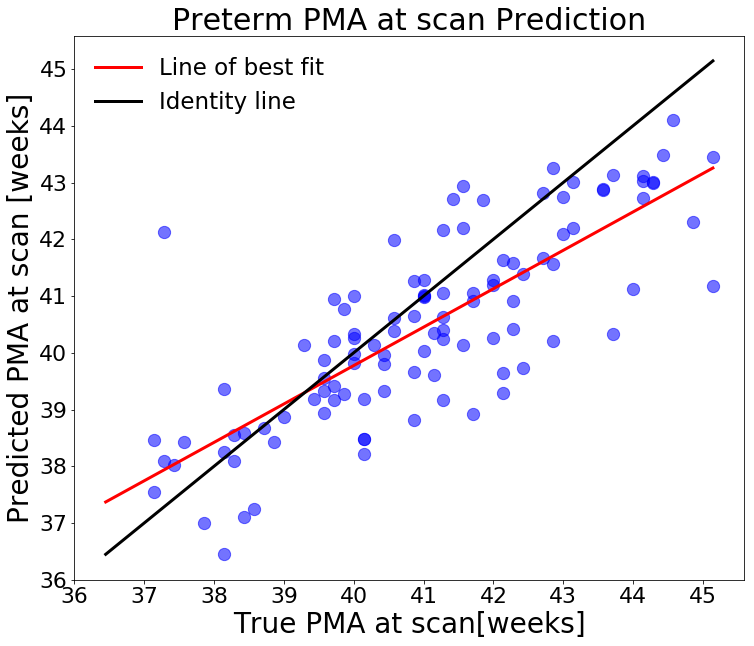

In [22]:
CORR_corrected = scipy.stats.pearsonr(list(PMA_PreTerm), list(Predictions_Preterm))
model = LinearRegression()
Model = model.fit(np.array(PMA_PreTerm).reshape(-1,1), np.array(Predictions_Preterm))
coeff = Model.coef_
intercept = Model.intercept_
print('Correlation is:', CORR_corrected)
xx = np.linspace(min(Predictions_Preterm), max(PMA_PreTerm), 5)
yy = coeff*xx + intercept

MAE_preterm_corrected = Get_Mean_Absolute_Error(np.array(PMA_PreTerm), np.array(Predictions_Preterm))
print('MAE preterm corrected:', MAE_preterm_corrected)

plt.figure(figsize = (12,10))
plt.scatter(PMA_PreTerm, Predictions_Preterm, marker = 'o', alpha = 0.55, color = 'b', s = 150)
plt.plot(xx,yy, label = 'Line of best fit', color = 'r', lw = 3)
plt.plot(xx, xx, color = 'k', label = 'Identity line', lw = 3)
title = str('Corrected Prediction: MAE:' + str(MAE_preterm_corrected) + 'Corr:' + str('  ' + str(np.round(CORR_corrected[0],2)) + '--' + str(CORR_corrected[1])))
plt.xlabel('True PMA at scan[weeks]', fontsize = 28)
plt.ylabel('Predicted PMA at scan [weeks]', fontsize = 28)
plt.legend(fontsize = 23, frameon = False)
plt.xticks([36, 37, 38, 39, 40, 41, 42, 43, 44, 45], fontsize = 22)
plt.yticks([36, 37, 38, 39, 40, 41, 42, 43, 44, 45], fontsize = 22)
plt.title('Preterm PMA at scan Prediction', fontsize = 30)
plt.savefig('Preterm_PMA_Prediction.png', dpi=250)

# Correlate residuals with outcome

## Utils functions

In [15]:
def Match_OutcomeData_With_Structural_PreTerm(ytestNames, OutcomeNames, Residuals_, Outcome):

    Full_Matching = []

    Outcomes_Matched = []
    Residual_Matched = []

    for i in range(len(ytestNames)):
        if ytestNames[i] in OutcomeNames:
            Index = OutcomeNames.index(ytestNames[i])
            if math.isnan(Outcome[Index]) == 0: #Verify if outcome exists
          
                Full_Matching.append([Residuals_[i], Outcome[Index], ytestNames[i], OutcomeNames[Index]])
                Outcomes_Matched.append(Outcome[Index])
                Residual_Matched.append(Residuals_[i])
    return Full_Matching, Outcomes_Matched, Residual_Matched

def Pandas_DataFrame_to_list(pd_df, Column):
    #This is just to correctly read in CSV files
    LIST = []
    pd_df_col = pd_df[Column]
    for i in range(len(pd_df_col)):
        LIST.append(pd_df_col[i])
    return LIST


## Compute brain maturation index

Brain maturation index is here called "Residual(s)" as it presents the difference between true and predicted. This is just a naming difference. 

In [ ]:
Residuals_PreTerm = []

for i in range(NumberOfPreTerms):
    #Computing predicted - true p
    Residuals.append(float(Predictions_Preterm[i] - PMA_PreTerm[i])) 
    

## Compute correlation between brain maturation index and each outcome

SPEARMAN - Model: Fine Motor ---Correlation is: 0.0878 and p value is: 0.5444 N = 50
PEARSON - Model: Fine Motor ---Correlation is: 0.06591 and p value is: 0.64927 N = 50
SPEARMAN - Model: Gross Motor ---Correlation is: 0.3374 and p value is: 0.0166 N = 50
PEARSON - Model: Gross Motor ---Correlation is: 0.41318 and p value is: 0.00286 N = 50
SPEARMAN - Model: Receptive ---Correlation is: 0.1229 and p value is: 0.3952 N = 50
PEARSON - Model: Receptive ---Correlation is: 0.14997 and p value is: 0.29856 N = 50
SPEARMAN - Model: Expressive ---Correlation is: 0.2474 and p value is: 0.0832 N = 50
PEARSON - Model: Expressive ---Correlation is: 0.25011 and p value is: 0.07982 N = 50
SPEARMAN - Model: Cog ---Correlation is: 0.2359 and p value is: 0.0991 N = 50
PEARSON - Model: Cog ---Correlation is: 0.21107 and p value is: 0.14119 N = 50


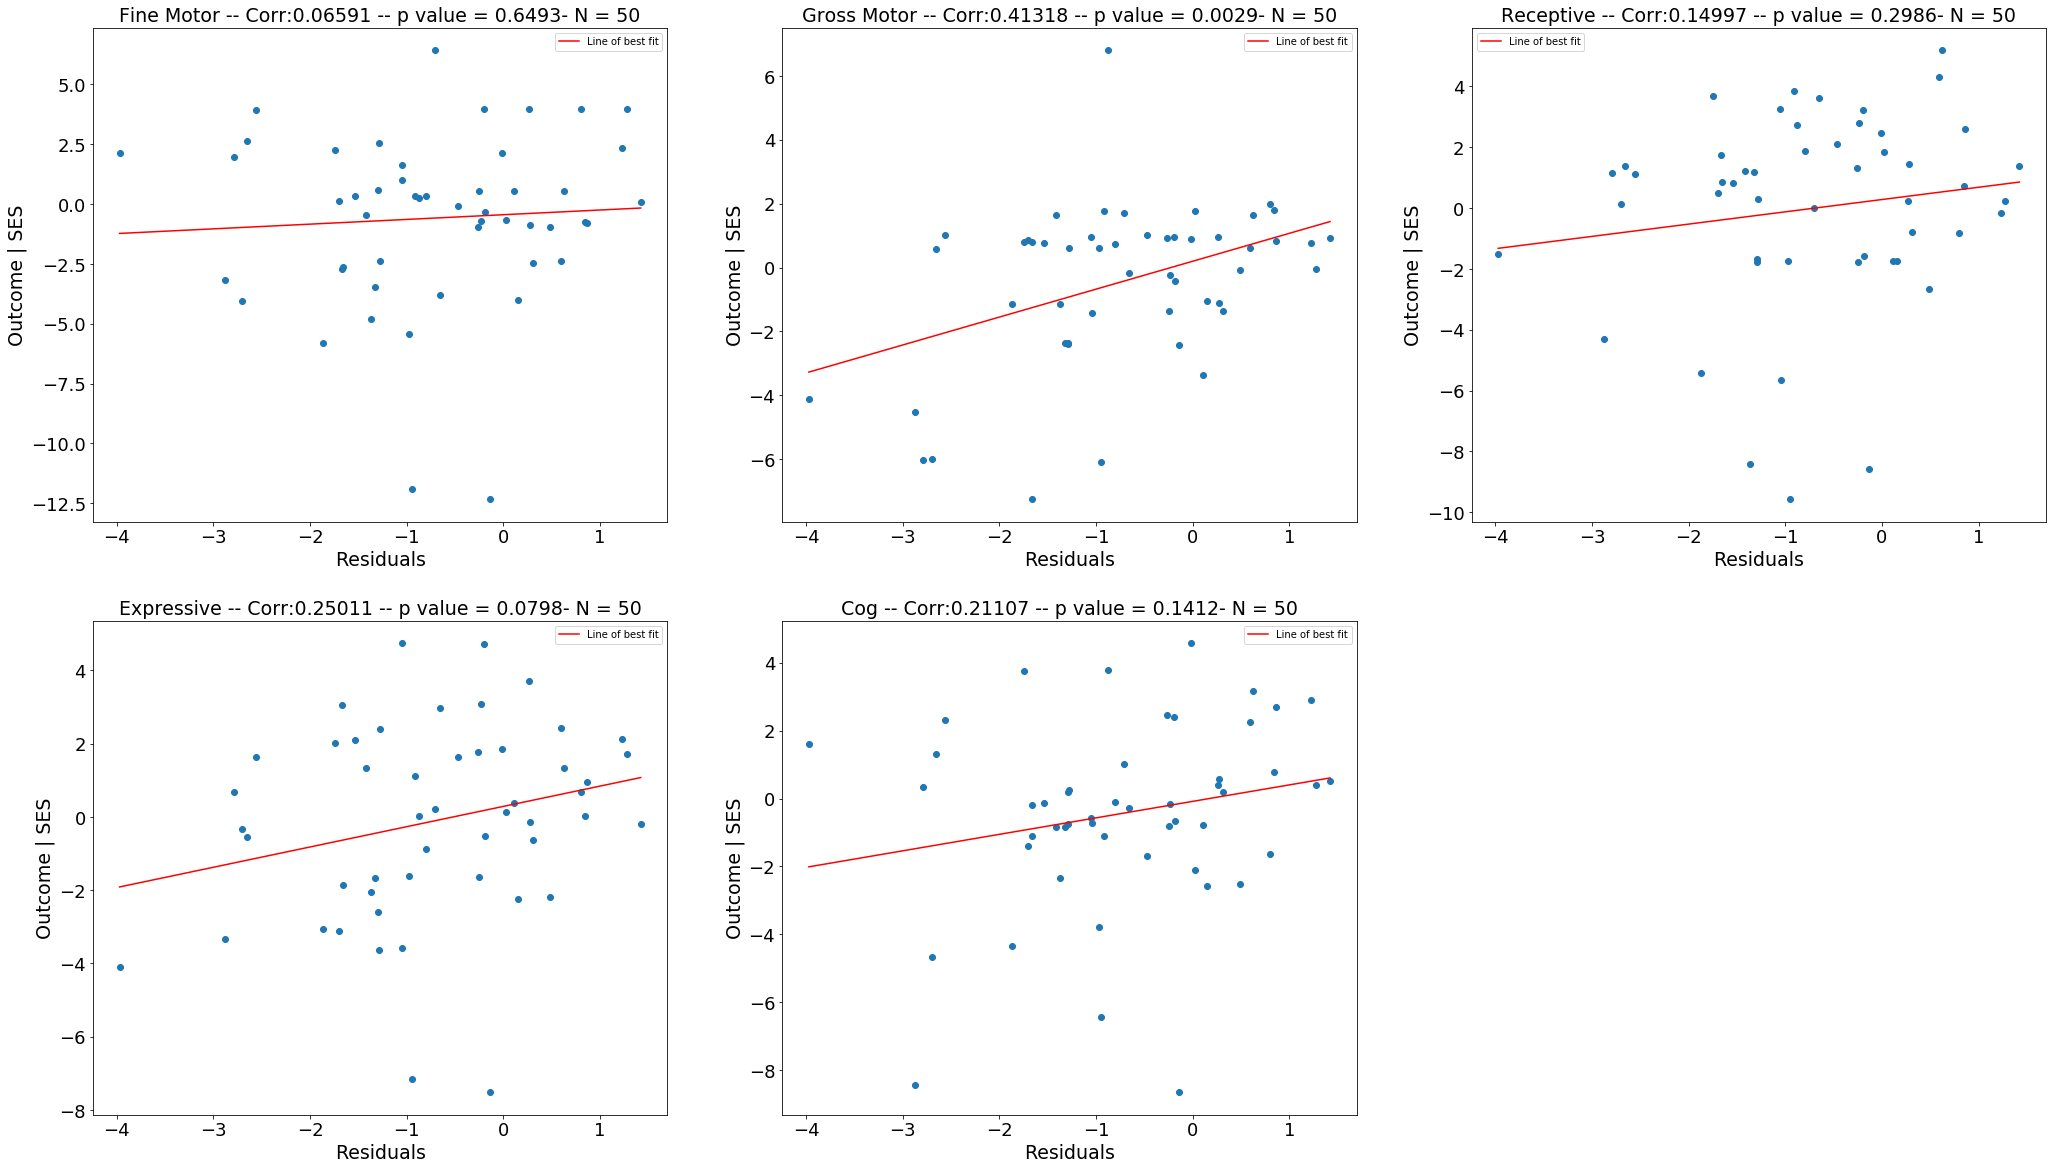

In [16]:
n = 1
plt.figure(figsize = (35,20))
Bayley_Outcomes = ['Fine Motor', 'Gross Motor', 'Receptive', 'Expressive', 'Cog']
path_to_outcomes = 'C:/Users/Yassine/Documents/3rd Year Project/Corrected Outcomes Folder/'
for Outcome in Bayley_Outcomes:
    
    File_pd = pd.read_csv(str(path_to_outcomes + Outcome + '.csv'))
    Corrected_Outcome = np.array(Pandas_DataFrame_to_list(File_pd, 'CORRECTED_OUTCOME'))
    Outcome_Names = Pandas_DataFrame_to_list(File_pd, 'SUBJECT ID')
  
    MATCHING, Outcome_Matched, Residual_Matched = Match_OutcomeData_With_Structural_PreTerm(ytestNames = Names_PreTerm, OutcomeNames = Outcome_Names,\
                                               Residuals_ = Residuals_PreTerm, Outcome = Corrected_Outcome)
    plt.subplot(2, 3, n)

    plt.scatter(Residual_Matched, Outcome_Matched) 
    plt.xlabel('Residuals', fontsize = 19)
    plt.ylabel('Outcome | SES', fontsize = 19)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)


    CORR = scipy.stats.pearsonr(Residual_Matched, Outcome_Matched)
    model = LinearRegression()
    Model = model.fit(np.array(Residual_Matched).reshape(-1,1), np.array(Outcome_Matched))
    coeff = Model.coef_
    intercept = Model.intercept_
    CORR_SPEARMAN = scipy.stats.spearmanr(Residual_Matched, Outcome_Matched)
    print('SPEARMAN - Model:', Outcome, '---Correlation is:', np.round(CORR_SPEARMAN[0], 4), 'and p value is:', np.round(CORR_SPEARMAN[1], 4), 'N =', len(Outcome_Matched))
    print('PEARSON - Model:', Outcome, '---Correlation is:', np.round(CORR[0], 5), 'and p value is:', np.round(CORR[1], 5), 'N =', len(Outcome_Matched))
    x = np.linspace(min(Residual_Matched), max(Residual_Matched), 5)
    y = coeff*x + intercept
    plt.plot(x,y, label = 'Line of best fit', color = 'r')
    title = str(Bayley_Outcomes[n-1] + ' -- Corr:' + str(str(np.round(CORR[0],5)) + ' -- p value = ' + str(np.round(CORR[1],4))) +  '- N = ' +  str(len(Outcome_Matched)))
    plt.title(title, fontsize = 19)
    n = n+1
    plt.legend()
  




## Visualize significant association

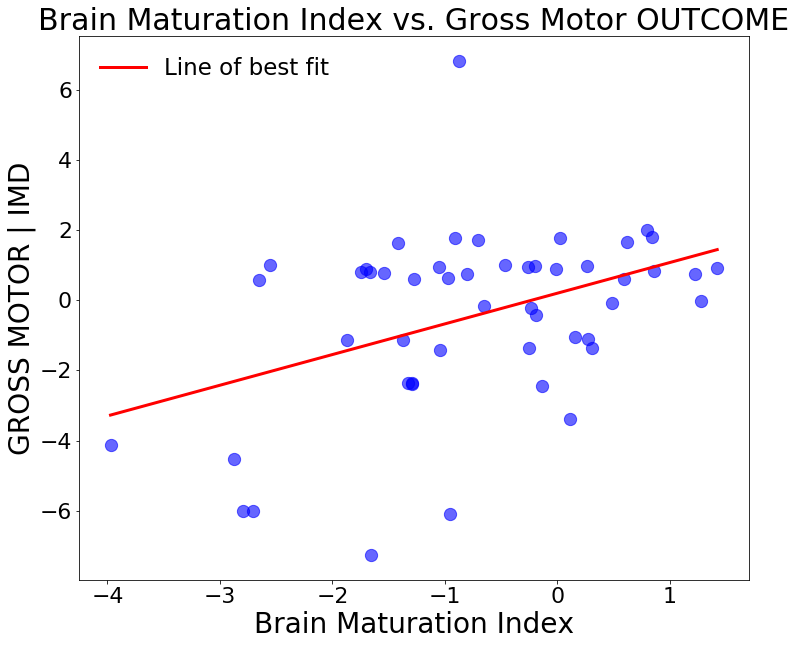

In [23]:
n = 1
plt.figure(figsize = (12,10))
Bayley_Outcomes = ['Gross Motor']
path_to_outcomes = 'C:/Users/Yassine/Documents/3rd Year Project/Corrected Outcomes Folder/'
for Outcome in Bayley_Outcomes:
    
    File_pd = pd.read_csv(str(path_to_outcomes + Outcome + '.csv'))
    Corrected_Outcome = np.array(PD_DF_to_list(File_pd, 'CORRECTED_OUTCOME'))
    Outcome_Names = PD_DF_to_list(File_pd, 'SUBJECT ID')
  
    MATCHING, Outcome_Matched, Residual_Matched = Match_OutcomeData_With_Structural_PreTerm(ytestNames = Names_PreTerm, OutcomeNames = Outcome_Names,\
                                               Residuals_ = Residuals_PreTerm, Outcome = Corrected_Outcome)

    

    CORR = scipy.stats.pearsonr(Residual_Matched, Outcome_Matched)
    model = LinearRegression()
    Model = model.fit(np.array(Residual_Matched).reshape(-1,1), np.array(Outcome_Matched))
    coeff = Model.coef_
    intercept = Model.intercept_
    CORR_SPEARMAN = scipy.stats.spearmanr(Residual_Matched, Outcome_Matched)
    x = np.linspace(min(Residual_Matched), max(Residual_Matched), 5)
    y = coeff*x + intercept
    
    
    plt.scatter(Residual_Matched, Outcome_Matched, marker = 'o', s = 150, alpha = 0.6, color = 'b') 
    plt.plot(x,y, label = 'Line of best fit', color = 'r', lw = 3)
    TITLE = str('Brain Maturation Index vs. ' + Bayley_Outcomes[n-1] + ' OUTCOME')
    plt.xlabel('Brain Maturation Index', fontsize = 28)
    plt.ylabel(str(str(Bayley_Outcomes[n-1]).upper() + ' | IMD'), fontsize = 28)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(fontsize = 23, loc = 2, frameon = False)
    plt.title(TITLE, fontsize = 30)
    plt.savefig('Brain_Maturation_Index_Gross_Motor.png', dpi=250)


